In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438445 sha256=d3725e179d6b960880ae1d1c6cc18b28efb8038c97118c4dd4c82a5419dd27e4
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


$\Delta x = \frac{b-a}{N}$

the approximation integral:
$\int_a^b \mathrm{f(x)}\,\mathrm{d}x \approx \frac {\Delta x}{2}\sum_{i=k}^{N}(f(x_{k-1})+f(x_{k}))$

Let's solve: a = 0, b = 10, $f(x) = x^{2}$

$\int_0^{10} \mathrm{x^{2}}\,\mathrm{d}x = \left.\frac{x^{3}}{3} \right|_0^{10} = 333.3$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def trap_rule(a = 0, b = 10,N = 100):

  delta_x = (b-a)/N
  x_dots = np.linspace(a, b, N+1, endpoint=True)
  f = np.zeros(N+1)
  f[0] = x_dots[0]**2
  f[N] = x_dots[N] **2
  for i in range(1,N):
    f[i] = 2*x_dots[i]**2
    
  return round(delta_x*f.sum()/2,1)

print(f'Trapezoidal rule gives - {trap_rule(N=101)}')


Trapezoidal rule gives - 333.3


In [ ]:
results = np.array([trap_rule(N=n) for n in range(1,102)])

Text(0, 0.5, 'Integration error')

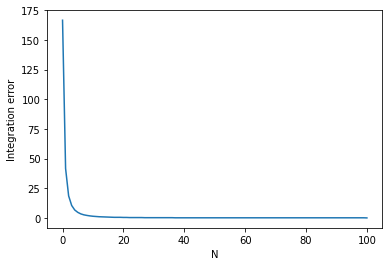

In [ ]:
plt.plot(abs(results-333.3))
plt.xlabel('N')
plt.ylabel('Integration error')

In [ ]:
%%writefile task7.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import timeit

start = timeit.default_timer()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

N = 100
my_n = int((N+1)/size)
a = 0
b = 10

delta_x = (b-a)/N
x_dots = np.linspace(a, b, N+1, endpoint=True)
#print(x_dots)

if rank == size-1:
  cur_x = x_dots[rank*my_n:]
else:
  cur_x = x_dots[rank*my_n:(rank+1)*my_n]

f = np.zeros(cur_x.shape[0], dtype = np.float64)
#print('my_n', my_n)
#print(f'rank - {rank}, cur_x - {cur_x}')

for i in range(cur_x.shape[0]):
  f[i] = 2*cur_x[i]**2

f= list(f)

#print('my_n', my_n)
#print('f', f)


if rank == 0:
  pass
  #f_total = np.zeros(N, dtype = np.float64)
else:
  f_total = None


#comm.Gather([f,my_n,MPI.FLOAT], f_total, root = 0)
f_total = comm.gather(f, root = 0)
#print('f_total',f_total)
if rank == 0:
  f_total = np.array(f_total, dtype=object)
  f_total = np.hstack(f_total)
  #print('stack',f_total)
  f_total[-1] = f_total[-1]/2
  print(round(f_total.sum()*(b-a)/N/2,1))

TIME = timeit.default_timer() - start

TIME_gen = comm.reduce(TIME, op=MPI.SUM, root = 0)
if rank == 0:
    print('final',TIME_gen/ size)


Overwriting task7.py


In [ ]:
!mpirun --allow-run-as-root -n 9 python task7.py

333.4
final 0.0818994399998903


Text(0, 0.5, 'Speedup')

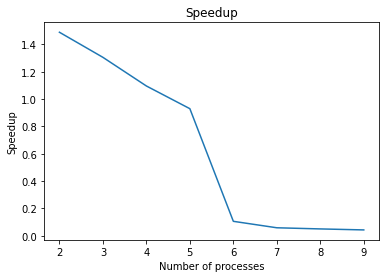

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
time_1_proc = 0.003457668999544694

proc_time = np.array([
    0.0023218920005092514,
    0.0026485103329226454,
    0.0031553482494928176,
    0.003719571599867777,
    0.032890088166216934,
    0.05972688857114657,
    0.06983980450013405,
    0.0818994399998903
])

plt.plot(1+np.array(range(1,proc_time.shape[0]+1)), time_1_proc/proc_time)
plt.title('Speedup')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')

In [ ]:
%%writefile task7.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import timeit

start = timeit.default_timer()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

N = 100
my_n = int((N+1)/size)
a = 0
b = 10

delta_x = (b-a)/N
x_dots = np.linspace(a, b, N+1, endpoint=True)
#print(x_dots)

cur_x = x_dots[rank*my_n:(rank+1)*my_n]

f = np.zeros(cur_x.shape[0], dtype = np.float64)
#print('my_n', my_n)
#print(f'rank - {rank}, cur_x - {cur_x}')

for i in range(cur_x.shape[0]):
  f[i] = 2*cur_x[i]**2

f= list(f)

#print('my_n', my_n)
#print('f', f)


if rank == 0:
  pass
  #f_total = np.zeros(N, dtype = np.float64)
else:
  f_total = None


#comm.Gather([f,my_n,MPI.FLOAT], f_total, root = 0)
f_total = comm.gather(f, root = 0)
#print('f_total',f_total)
if rank == 0:
  f_total = np.array(f_total, dtype=object)
  f_total = np.hstack(f_total)
  #print('stack',f_total)
  f_total[-1] = f_total[-1]/2
  print(round(f_total.sum()*(b-a)/N/2,1))

TIME = timeit.default_timer() - start

TIME_gen = comm.reduce(TIME, op=MPI.SUM, root = 0)
if rank == 0:
    print('final',TIME_gen/ size)


Overwriting task7.py


In [ ]:
!mpirun --allow-run-as-root -n 6 python task7.py

285.8
final 0.09536419816701407
